In [1]:
import os
import gzip
import tarfile

import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import img_as_ubyte
from skimage.exposure import histogram

import cv2

# Torch
import torch
from torch import nn
import torch.nn.functional as F

# Model
from torchvision.models import resnet18

# Data Loading
from torchvision import datasets
from torch.utils import data

# Data augmentation
from torch import tensor
import torchvision.transforms as transforms

# Load data

In [13]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [14]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

mnist_folder = os.path.join('data', 'MNIST')

train_images_path = os.path.join(mnist_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(mnist_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(mnist_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(mnist_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

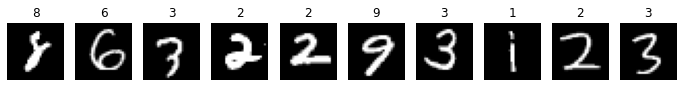

In [15]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

# Load results from task 0

In [ ]:
def load_segmentation_task0(filepath):
    segmented = pd.read_pickle(filepath)
    values = series[0].values
    imgs = [v[-1] for v in values]
    ranks = [v[0][0] for v in values]
    suits = [v[0][1] for v in values]

    df_task0 = pd.DataFrame({"rank": ranks, "suit": suits, "image": imgs})
    df_numbers_only = df_task0[~df_task0['rank'].isin(['Q', 'J', 'K'])].drop_index(drop=True)
    df_not_numbers = df_task0[df_task0['rank'].isin(['Q', 'J', 'K'])].drop_index(drop=True)
    
    return df_task0, df_numbers_only, df_not_numbers
  
def preprocess_segmented_task0(img):
    inverted = img_as_ubyte(skimage.util.invert(img))
    _, binary = cv2.threshold(inverted, 100, 120, cv2.THRESH_BINARY)
    blurred = cv2.GaussianBlur(binary, (3,3), 0)

    return blurred

In [2]:
series = pd.read_pickle(os.path.join('data', 'classification_data', 'all_games_classification_series.pickle'))

In [3]:
values = series[0].values

In [4]:
imgs = [v[-1] for v in values]
ranks = [v[0][0] for v in values]
suits = [v[0][1] for v in values]

df_task0 = pd.DataFrame({"rank": ranks, "suit": suits, "image": imgs})
df_task0.head()

,rank,suit,image
0,Q,S,"[[0.7374045377275249, 0.7353642493485804, 0.73..."
1,8,H,"[[0.7246389496516452, 0.7241287553848418, 0.72..."
2,J,H,"[[0.7858449449682893, 0.7854452166625326, 0.78..."
3,0,S,"[[0.7337403886006049, 0.7341374836873047, 0.73..."
4,5,S,"[[0.7297011465810356, 0.7287990243210922, 0.72..."


In [5]:
df_numbers_only = df_task0[~df_task0['rank'].isin(['Q', 'J', 'K'])]

In [11]:
def preprocess_segmented_task0(img):
    inverted = img_as_ubyte(skimage.util.invert(img))
    _, binary = cv2.threshold(inverted, 100, 120, cv2.THRESH_BINARY)
    blurred = cv2.GaussianBlur(binary, (3,3), 0)

    return blurred

(-0.5, 27.5, 27.5, -0.5)

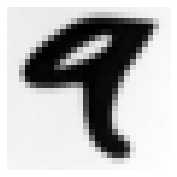

In [7]:
img = ca_deconne.image[4]
inverted = img_as_ubyte(skimage.util.invert(img))
_, binary = cv2.threshold(inverted, 100, 120, cv2.THRESH_BINARY)
blurred = cv2.GaussianBlur(binary, (3,3), 0)

fig, ax = plt.subplots(1, 4, figsize=(5, 3))

ax[0].imshow(img, cmap='gray')
ax[1].imshow(inverted, cmap='gray')
ax[2].imshow(binary, cmap='gray')
ax[3].imshow(blurred, cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')

plt.show()

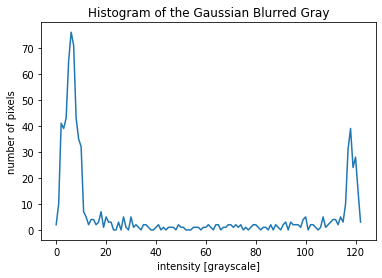

In [9]:
# Display the histogram of the image
hist, hist_centers = histogram(inverted)
plt.plot(hist)
plt.title("Histogram of the Gaussian Blurred Gray")
plt.xlabel("intensity [grayscale]")
plt.ylabel("number of pixels")
plt.show()

## Ranks that are not numbers

In [39]:
df_not_numbers = df_task0[df_task0['rank'].isin(['Q', 'J', 'K'])]

In [40]:
kings = df_not_numbers[df_not_numbers['rank'] == 'K'].reset_index(drop=True)
queens = df_not_numbers[df_not_numbers['rank'] == 'Q'].reset_index(drop=True)
jacks = df_not_numbers[df_not_numbers['rank'] == 'J'].reset_index(drop=True)

# Data loader and augmentation

In [16]:
def augment_data(data, transform):
    augmented_imgs = []
    for img in data:
        augmented = skimage.img_as_ubyte(transform_aug(img)).reshape(image_shape)
        augmented_imgs.append(augmented)
        
    return np.array(augmented_imgs)

In [18]:
transform_aug = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomAffine(degrees=25, scale=(0.8, 1.1), shear=20),
                transforms.ToTensor(),
            ]
        )

augmented_train = augment_data(train_images, transform_aug)

In [19]:
class MNISTDataset(data.Dataset):
    def __init__(self, imgs, labels, transform):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        data = self.imgs[idx]
        if self.transform:
            data = self.transform(data)
        return (data, self.labels[idx])

In [20]:
# Parameters of our DataLoader
params = {'batch_size': 128,
          'shuffle': True}

# Creation of a train/test dataset & dataloader
train_merged_images = np.concatenate((train_images, augmented_train))
train_merged_labels = np.concatenate((train_labels, train_labels))

ds_train = MNISTDataset(train_merged_images, train_merged_labels, transform=transforms.ToTensor())
dl_train = data.DataLoader(ds_train, **params)

ds_test = MNISTDataset(test_images, test_labels, transform=transforms.ToTensor())
dl_test = data.DataLoader(ds_test, **params)

In [ ]:
to_test = np.array([v for v in df_numbers_only.image.apply(preprocess_result_task0)])

ds_test_task0 = MNISTDataset(to_test, df_numbers_only['rank'].to_numpy().astype(np.int64), 
                             transform=transforms.ToTensor())
dl_test_task0 = data.DataLoader(ds_test_task0, **params)

# Model

### ResNet

In [21]:
# model = resnet18(num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### CNN 1

In [22]:
# defining the model architecture
class Net1(nn.Module):   
    def __init__(self):
        super(Net1, self).__init__()

        self.cnn_layers = nn.Sequential(
          # Defining first 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining second 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [23]:
model1 = Net()

### CNN 2

In [24]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [25]:
model2 = Net2()

### CNN 3

In [33]:
# Create CNN Model
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        
        return out

In [34]:
model3 = Net3()

## Training

In [36]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 1e-3
opt = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [37]:
def train_loop(dataloader, model, loss_func, optimizer):
    for it, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)            # Forward pass
        loss = loss_func(pred, y)  # Compute the loss

        # Backpropagation
        optimizer.zero_grad()      # Reinitialise the accumulated gradients
        loss.backward()            # Recompute the new gradients
        optimizer.step()           # Update the parameters of the model
        
        # Compute the accuracy on this batch of images
        accuracy_tr = (pred.argmax(1) == y).type(torch.float).sum().item() / len(X)
        
        #if (it+1 == len(dataloader)):
        print('It {}/{}:\tLoss train: {:.5f}, Accuracy train: {:.2%}'.
              format(it + 1, len(dataloader), loss, accuracy_tr), end='\r')
    print()
    
def test_loop(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    test_loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Statistics over all the batchs
    test_loss /= size
    accuracy /= size    
    
    print(f"Test Error:\n\tAvg loss: {test_loss:.5f}, Accuracy: {accuracy:.2%}\n")

In [38]:
epochs = 7

# Train & test our model until convergence (here 15 epochs is sufficient as we don't have too many parameters)
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loop(dl_train, model2, criterion, opt)
    test_loop(dl_test, model2, criterion)

Epoch 1
-------------------------------
It 938/938:	Loss train: 0.04257, Accuracy train: 98.44%%
Test Error:
	Avg loss: 0.00033, Accuracy: 98.62%

Epoch 2
-------------------------------
It 938/938:	Loss train: 0.00696, Accuracy train: 100.00%
Test Error:
	Avg loss: 0.00031, Accuracy: 98.86%

Epoch 3
-------------------------------
It 938/938:	Loss train: 0.02127, Accuracy train: 98.44%%
Test Error:
	Avg loss: 0.00022, Accuracy: 98.97%

Epoch 4
-------------------------------
It 938/938:	Loss train: 0.01927, Accuracy train: 98.44%%
Test Error:
	Avg loss: 0.00016, Accuracy: 99.33%

Epoch 5
-------------------------------
It 938/938:	Loss train: 0.00016, Accuracy train: 100.00%
Test Error:
	Avg loss: 0.00020, Accuracy: 99.26%

Epoch 6
-------------------------------
It 938/938:	Loss train: 0.04309, Accuracy train: 98.44%%
Test Error:
	Avg loss: 0.00021, Accuracy: 99.31%

Epoch 7
-------------------------------
It 938/938:	Loss train: 0.02774, Accuracy train: 100.00%
Test Error:
	Avg loss

In [41]:
to_test = np.array([v for v in df_numbers_only.image.apply(preprocess_result_task0)])
ds_test_task0 = MNISTDataset(to_test, df_numbers_only['rank'].to_numpy().astype(np.int64), 
                             transform=transforms.ToTensor())
dl_test_task0 = data.DataLoader(ds_test_task0, **params)

In [43]:
test_loop(dl_test_task0, model2, criterion)

Test Error:
	Avg loss: 0.00659, Accuracy: 75.99%

